# Rejig mfbmCNN on ViaLactea coldens rejig

Use the mfbmCNN model (32px) model on ViaLactea coldens. 

Rejigged version.

Nans masked with a window

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import cv2
import pickle
import pandas as pd
import re
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import cv2
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import uniform_filter
from scipy.stats import mode

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
PPMAP_PATH = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'
MODEL_PATH = 'D:/Workshop/PhD/Models/model32px_large'
RESULTS_PATH = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_redux/'

N_PIX = 32

In [3]:
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0     

In [4]:
progress_df = pd.read_csv(f'{RESULTS_PATH}progress.csv')
progress_df

,Direction,H,S,coords
0,l000,0.119728,2.487259,"[359.97972099949186, 0.040683222371426846]"


In [5]:
a = np.empty((N_PIX,N_PIX))
a[:] = np.nan
a = np.asarray([np.array(a).reshape(N_PIX, N_PIX, 1)])
default_values = model.predict(a)[0]
default_values

array([0.9994058, 1.0947635], dtype=float32)

In [6]:
def HS_measurements(img, model, N_p):
    H_array = []
    S_array = []
    #img = np.nan_to_num(img)
    for y in tqdm(np.arange(np.shape(img)[1])):
        X = []
        for x in np.arange(np.shape(img)[0]):
            sub_field = img[int(x-N_p/2):int(x+N_p/2),int(y-N_p/2):int(y+N_p/2)]
            if np.shape(sub_field) == (N_p,N_p):
                
#                 sub_field = sub_field/np.nanmax(sub_field) * 255
#                 sub_field = np.uint8(sub_field)
#                 mask = np.uint8(np.isnan(sub_field))
#                 sub_field = cv2.inpaint(sub_field,mask,3,cv2.INPAINT_TELEA)
                                
                m_1_field = np.mean(sub_field)
                s_1_field = np.std(sub_field)
                m_2_field = 0
                s_2_field = 1/4

                sub_field = sub_field * s_2_field/s_1_field
                sub_field += (m_2_field-m_1_field*s_2_field/s_1_field)
                sub_field[np.where(sub_field>1.)] = 1.
                sub_field[np.where(sub_field<-1.)] = -1.
                sub_field = (sub_field-np.min(sub_field))/(np.max(sub_field)-np.min(sub_field))
                
                sub_field = np.array(sub_field).reshape(N_p, N_p, 1)
                X.append(sub_field)
                
        if len(X) != 0:
            X = np.asarray(X)
            preds = model.predict(X)
            H_array.append(preds[:,0])
            S_array.append(preds[:,1])
            
    H_array = np.asarray(H_array).T
    S_array = np.asarray(S_array).T
       
    return H_array,S_array

In [ ]:
coords_list = []
H_list = []
S_list = []

for folder in os.listdir(PPMAP_PATH):
    #construct tile number from folder name
    
    direction = folder[1:4]
    #check whether the particular tile has already been calculated in progress.csv
    if not (progress_df['Direction']==f'l{direction}').any():
        print(f'l{direction}')
        #load in the fits file
        hdu = fits.open(f'{PPMAP_PATH}{folder}/l{direction}_cdens.fits')[0]
        #load in the WCS and image data
        wcs = WCS(hdu.header)
        image_array = hdu.data
                
        #plot tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(np.log10(image_array), origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/Inputs/{direction}.png')
        plt.close()
        
        #start the H and S measurements
        H_array, S_array = HS_measurements(image_array, model, N_PIX)      
        np.savetxt(f'{RESULTS_PATH}H/raw_data/{direction}.txt',H_array)
        np.savetxt(f'{RESULTS_PATH}S/raw_data/{direction}.txt',S_array)
                           
        H_mod_array = np.where(H_array==mode(H_array)[0][0], 0, H_array)
        S_mod_array = np.where(S_array==mode(S_array)[0][0], 0, S_array)
    
        mask = H_mod_array.copy()
        mask[H_mod_array==0] = np.nan
        mask[H_mod_array!=0] = 1
        
        #plot raw H-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(H_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/H/raw_images/{direction}.png')
        plt.close()
        
        #plot raw S-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(S_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/S/raw_images/{direction}.png')
        plt.close()

        #Get average filter of H map and S map
        H_avg_array = uniform_filter(H_array, size=N_PIX, mode='mirror')*mask
        S_avg_array = uniform_filter(S_array, size=N_PIX, mode='mirror')*mask
        
        #plot avg H-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(H_avg_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/H/avg_images/{direction}.png')
        plt.close()
        
        #plot avg S-tile and save
        plt.figure(figsize=(1080/144, 1080/144), dpi=144)
        plt.imshow(S_avg_array, origin = 'lower')
        plt.colorbar()
        plt.title(f'l{direction}')
        plt.savefig(f'{RESULTS_PATH}/S/avg_images/{direction}.png')
        plt.close()
        
        #save the avg data
        np.savetxt(f'{RESULTS_PATH}H/avg_data/{direction}.txt',H_avg_array)
        np.savetxt(f'{RESULTS_PATH}S/avg_data/{direction}.txt',S_avg_array)
        
        #prepare the image for getting overall H and S
        img = image_array/np.nanmax(image_array) * 255
        img = np.uint8(img)
        size = np.shape(img)
        mask = np.uint8(np.isnan(img))
        array_conv=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
        centre_coords = pixel_to_skycoord(size[0]/2,size[0]/2, wcs)

        m_1_field = np.mean(array_conv)
        s_1_field = np.std(array_conv)
        m_2_field = 0
        s_2_field = 1/4

        x = array_conv * s_2_field/s_1_field
        x += (m_2_field-m_1_field*s_2_field/s_1_field)
        x[np.where(x>1.)] = 1.
        x[np.where(x<-1.)] = -1.
        x = (x-np.min(x))/(np.max(x)-np.min(x))

        x = cv2.resize(x, (N_PIX,N_PIX))    
        x = x.reshape(1, N_PIX, N_PIX, 1)

        preds = model.predict(x)[0]
        H=preds[0]
        S=preds[1]
        
        x = np.arange(0,size[0])
        y = np.arange(0,size[1])
        xx, yy = np.meshgrid(x, y)
        coords_grid = pixel_to_skycoord(xx,yy, wcs)
        coords = [centre_coords.l.degree, centre_coords.b.degree]
        
        data_cube = np.array([image_array,H_avg_array,S_avg_array,coords_grid.l.degree,coords_grid.b.degree])
        pickle_out = open(f'{RESULTS_PATH}DataCubes/l{direction}.pickle','wb')
        pickle.dump(data_cube,pickle_out)
        pickle_out.close()
        
        new_row = {'Direction':f'l{direction}',
                   'H':H,
                   'S':S,
                   'coords':coords}
        progress_df = progress_df.append(new_row,ignore_index=True)
        progress_df.to_csv(f'{RESULTS_PATH}progress.csv',index=False)

l002


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [18:14<00:00,  1.32it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l004


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [17:20<00:00,  1.38it/s]
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


l006


 15%|███████████▋                                                                   | 212/1440 [02:23<15:57,  1.28it/s]

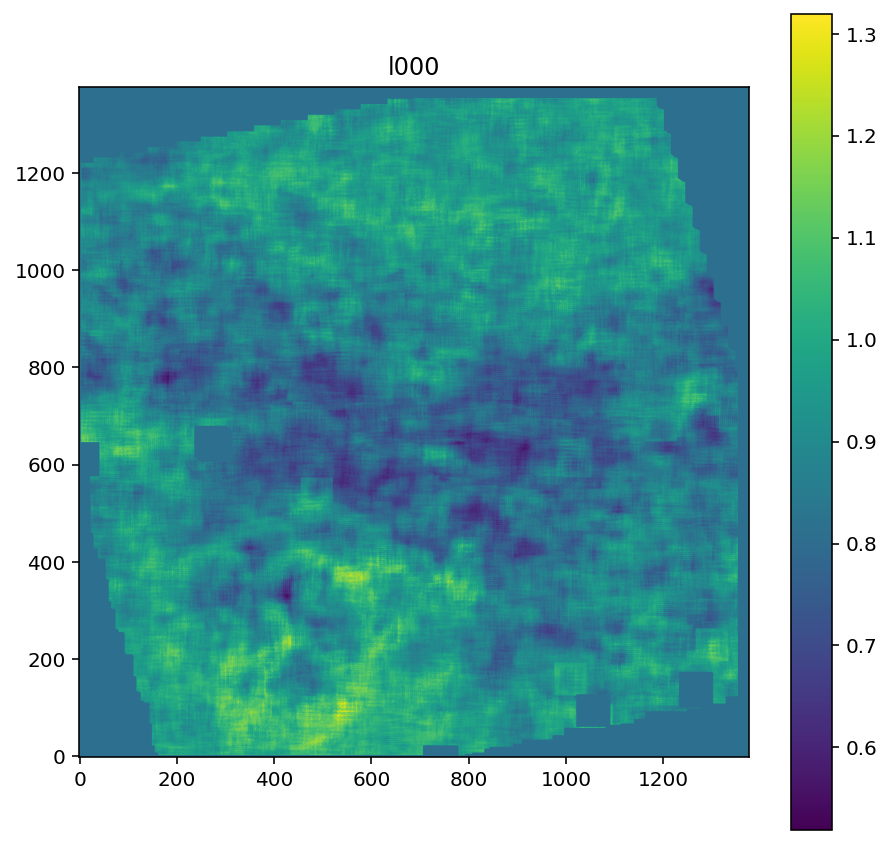

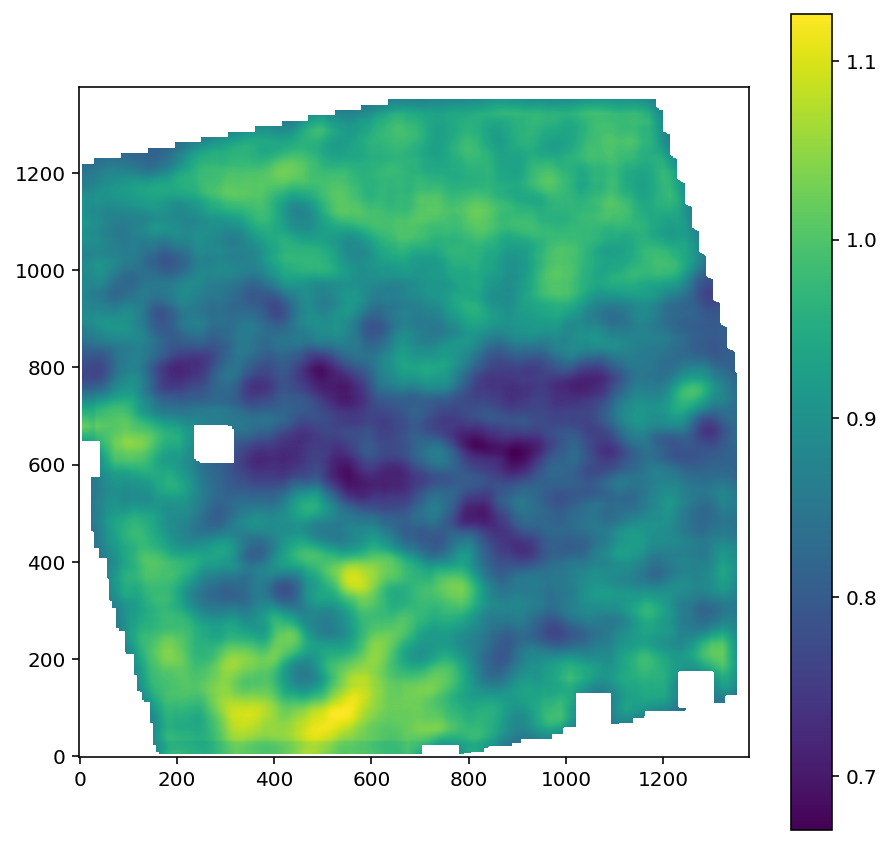

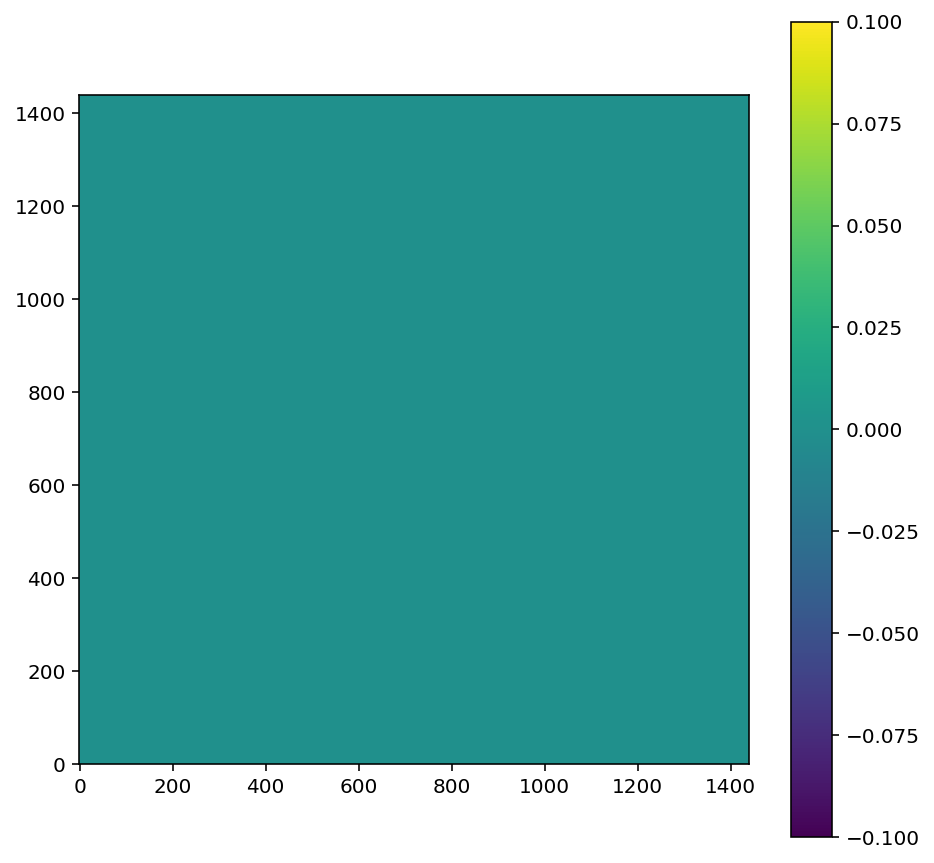

In [8]:
plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(H_array, origin = 'lower')
plt.colorbar()
plt.title(f'l{direction}')
#plt.savefig('D:/Workshop/PhD\Meetings/20220428/raw_H_02.png')
plt.show()

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(H_avg_array, origin = 'lower')
plt.colorbar()
#plt.savefig('D:/Workshop/PhD/Meetings/20220428/avg_H_02.png')
plt.show()

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(mask, origin = 'lower')
plt.colorbar()
#plt.savefig('D:/Workshop/PhD/Meetings/20220428/avg_H_02.png')
plt.show()

In [19]:
mode(H_array, axis=None)[0][0]

0.8101196

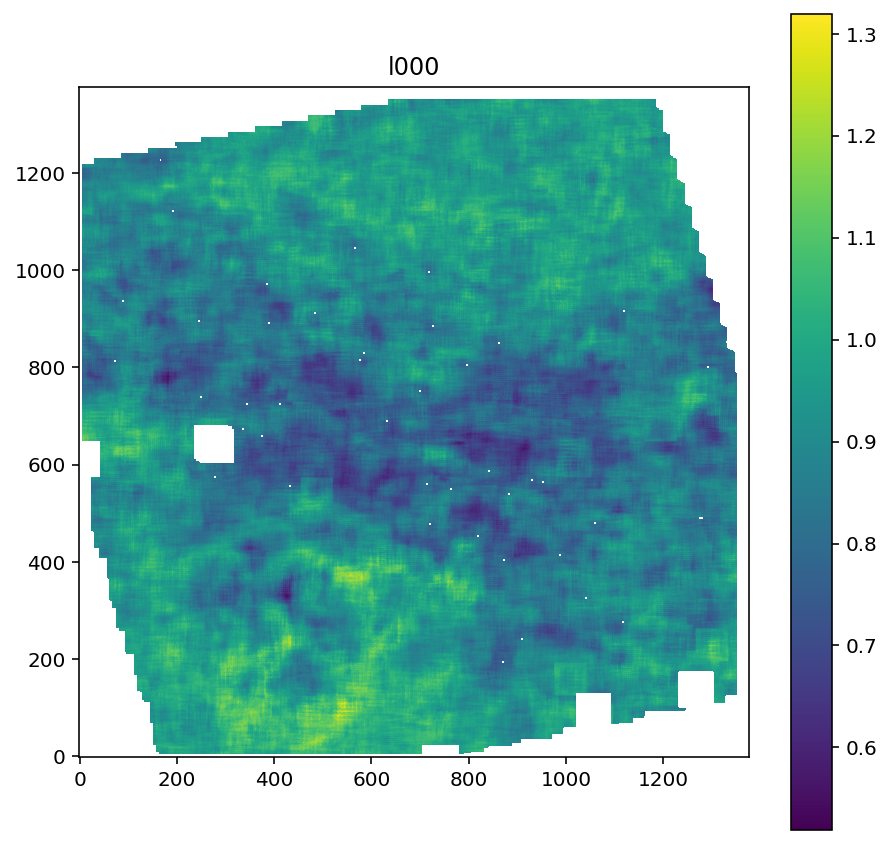

In [14]:
mask_test = H_array.copy()
mask_test[mask_test==0] = np.nan

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(mask_test, origin = 'lower')
plt.colorbar()
plt.title(f'l{direction}')
#plt.savefig('D:/Workshop/PhD\Meetings/20220428/raw_H_02.png')
plt.show()


In [66]:
H_array<=0.81012

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

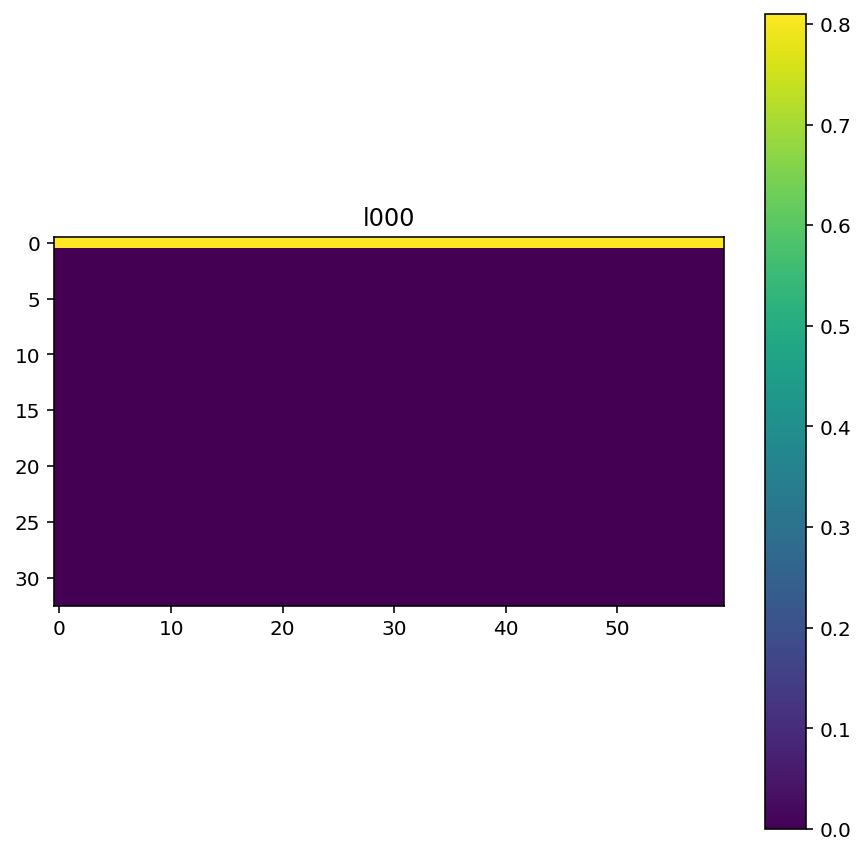

[[0.81011945 0.81011945 0.81011945 ... 0.81011945 0.81011945 0.81011945]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [61]:
plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.imshow(np.where(H_array!=0.8101196, H_array, 0)[1407:,40:100])#, origin = 'lower')
plt.colorbar()
plt.title(f'l{direction}')
#plt.savefig('D:/Workshop/PhD\Meetings/20220428/raw_H_02.png')
plt.show()

print(np.where(H_array!=0.8101196, H_array, 0)[1407:,40:100])

C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\matplotlib\axes\_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Matt\.conda\envs\tf2-gpu\lib\site-packages\matplotlib\axes\_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

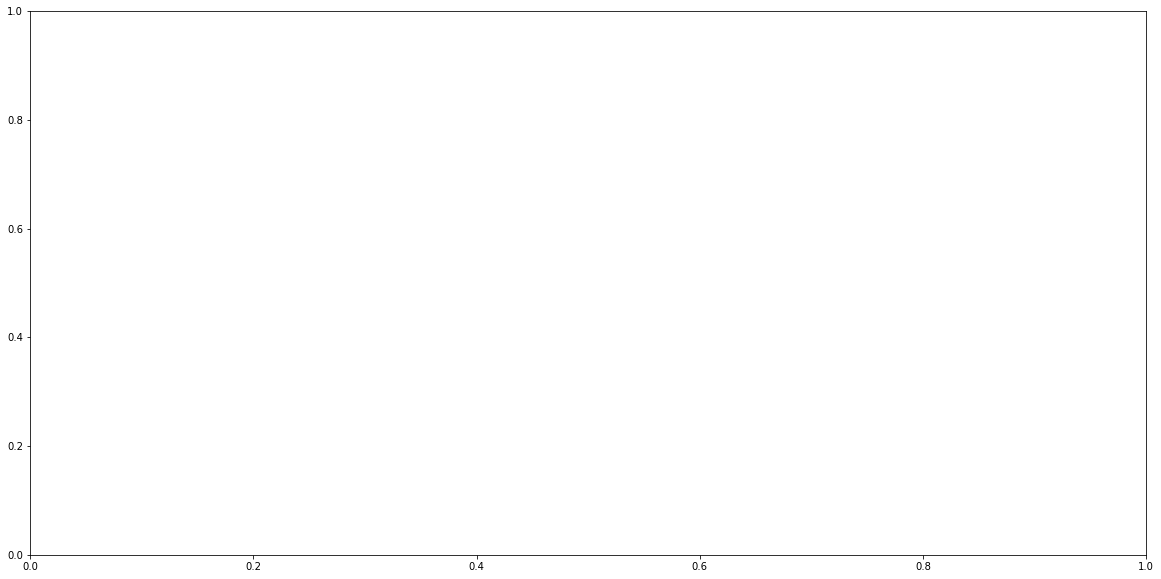

In [9]:
plt.figure(figsize=(20,10))
plt.hist(H_array_nans.flatten(), bins=100, density = True)
plt.xlabel('H')
plt.savefig('D:/Workshop/PhD/Meetings/20220428/mask_H_02_hist.png')
plt.show()